In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import math as math
from scipy.stats import boxcox
from random import randrange
from random import seed
from random import random
from random import gauss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Multiply, Concatenate, Dropout
from pyod.models.knn import KNN 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score,roc_curve,auc

In [2]:
data=pd.read_csv("synthetic_weather_data_wo_label_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)
data_labeled=pd.read_csv("synthetic_weather_data_wi_label_supervised_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)

In [3]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096   # 3 year
train= data.iloc[:-Ntest].copy()
test= data.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = data.index <=train.index[-1]
test_idx = data.index > train.index[-1]

data.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
data.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

data.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
data.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

data.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
data.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

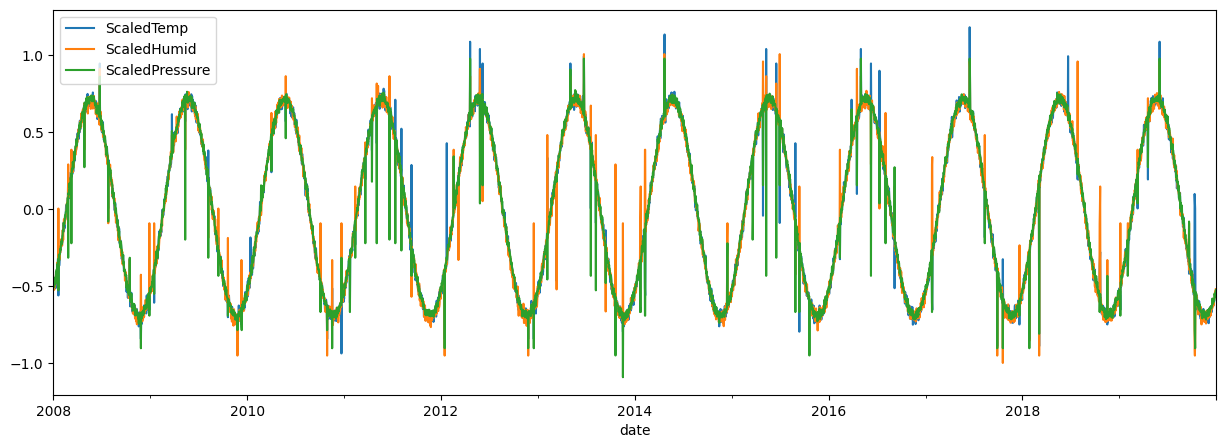

In [4]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

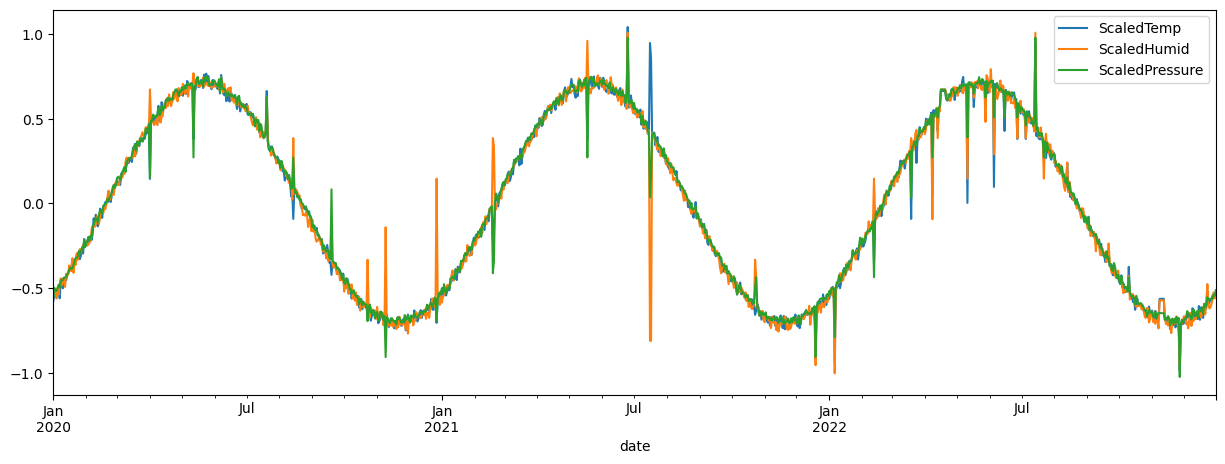

In [5]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [6]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

In [7]:
#Information from Physical Modeling
lag_order = 50

### Physical equation modeling with VAR using extended lag as 50

In [8]:
"""temp_pred= 0.15*temp(t-1)+0.04*temp(t-2)+0.03*humid(t-2)+0.03*humid(t-5)+0.05*temp(t-6)+0.03*humid(t-9)+0.03*temp(t-10)
              +0.03*humid(t-12)+0.05*pressure(t-13)+0.03*humid(t-15)+0.03*pressure(t-15)+0.03*pressure(t-18)+0.03*humid(t-21)
              -0.03*pressure(t-32)+0.05*temp(t-37)-0.03*pressure(t-38)-0.05*temp(t-49)-0.03*temp(t-50)-0.03*pressure(t-50)"""

'temp_pred= 0.15*temp(t-1)+0.04*temp(t-2)+0.03*humid(t-2)+0.03*humid(t-5)+0.05*temp(t-6)+0.03*humid(t-9)+0.03*temp(t-10)\n              +0.03*humid(t-12)+0.05*pressure(t-13)+0.03*humid(t-15)+0.03*pressure(t-15)+0.03*pressure(t-18)+0.03*humid(t-21)\n              -0.03*pressure(t-32)+0.05*temp(t-37)-0.03*pressure(t-38)-0.05*temp(t-49)-0.03*temp(t-50)-0.03*pressure(t-50)'

In [9]:
"""humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)
            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)"""

'humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)\n            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)'

In [10]:
"""pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)
                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)
                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)"""

'pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)\n                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)\n                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)'

### Temperature prediction from VAR Model

In [11]:
"""temp_pred= 0.15*temp(t-1)+0.04*temp(t-2)+0.03*humid(t-2)+0.03*humid(t-5)+0.05*temp(t-6)+0.03*humid(t-9)+0.03*temp(t-10)
              +0.03*humid(t-12)+0.05*pressure(t-13)+0.03*humid(t-15)+0.03*pressure(t-15)+0.03*pressure(t-18)+0.03*humid(t-21)
              -0.03*pressure(t-32)+0.05*temp(t-37)-0.03*pressure(t-38)-0.05*temp(t-49)-0.03*temp(t-50)-0.03*pressure(t-50)"""

'temp_pred= 0.15*temp(t-1)+0.04*temp(t-2)+0.03*humid(t-2)+0.03*humid(t-5)+0.05*temp(t-6)+0.03*humid(t-9)+0.03*temp(t-10)\n              +0.03*humid(t-12)+0.05*pressure(t-13)+0.03*humid(t-15)+0.03*pressure(t-15)+0.03*pressure(t-18)+0.03*humid(t-21)\n              -0.03*pressure(t-32)+0.05*temp(t-37)-0.03*pressure(t-38)-0.05*temp(t-49)-0.03*temp(t-50)-0.03*pressure(t-50)'

In [12]:
df_laggedtemp=pd.DataFrame()
df_laggedtemp['temp_L1']=df_combined['ScaledTemp'].shift(1)
df_laggedtemp['temp_L2']=df_combined['ScaledTemp'].shift(2)
df_laggedtemp['humid_L2']=df_combined['ScaledHumid'].shift(2)
df_laggedtemp['humid_L5']=df_combined['ScaledHumid'].shift(5)
df_laggedtemp['temp_L6']=df_combined['ScaledTemp'].shift(6)
df_laggedtemp['humid_L9']=df_combined['ScaledHumid'].shift(9)
df_laggedtemp['temp_L10']=df_combined['ScaledTemp'].shift(10)
df_laggedtemp['humid_L12']=df_combined['ScaledHumid'].shift(12)
df_laggedtemp['pressure_L13']=df_combined['ScaledPressure'].shift(13)
df_laggedtemp['humid_L15']=df_combined['ScaledHumid'].shift(15)
df_laggedtemp['pressure_L15']=df_combined['ScaledPressure'].shift(15)
df_laggedtemp['pressure_L18']=df_combined['ScaledPressure'].shift(18)
df_laggedtemp['humid_L21']=df_combined['ScaledHumid'].shift(21)
df_laggedtemp['pressure_L32']=df_combined['ScaledPressure'].shift(32)
df_laggedtemp['temp_L37']=df_combined['ScaledTemp'].shift(37)
df_laggedtemp['pressure_L38']=df_combined['ScaledPressure'].shift(38)
df_laggedtemp['temp_L49']=df_combined['ScaledTemp'].shift(49)
df_laggedtemp['temp_L50']=df_combined['ScaledTemp'].shift(50)
df_laggedtemp['pressure_L50']=df_combined['ScaledPressure'].shift(50)

In [13]:
df_vartemp=[df_laggedtemp['temp_L1'],df_laggedtemp['temp_L2'],df_laggedtemp['humid_L2'],df_laggedtemp['humid_L5'],
            df_laggedtemp['temp_L6'],df_laggedtemp['humid_L9'],df_laggedtemp['temp_L10'],
            df_laggedtemp['humid_L12'],df_laggedtemp['pressure_L13'],
            df_laggedtemp['humid_L15'],df_laggedtemp['pressure_L15'],
            df_laggedtemp['pressure_L18'],df_laggedtemp['humid_L21'],
            df_laggedtemp['pressure_L32'],df_laggedtemp['temp_L37'],
            df_laggedtemp['pressure_L38'],df_laggedtemp['temp_L49'],
            df_laggedtemp['temp_L50'],df_laggedtemp['pressure_L50'],df_combined['ScaledTemp']]
df_vartemp=pd.concat(df_vartemp,axis=1)

In [14]:
df_vartemp.dropna(inplace=True)

In [15]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_temp = df_vartemp.iloc[:-nest_samples].copy()
test_temp = df_vartemp.iloc[-nest_samples:].copy()

In [16]:
y_train_temp = train_temp.iloc[:, -1].values
y_test_temp = test_temp.iloc[:, -1].values

In [17]:
X_train_temp=train_temp.iloc[:,:-1].values
x_test_temp=test_temp.iloc[:,:-1].values

### Build Custom Layer

In [18]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, coeffs):
        super(CustomLayer, self).__init__()
        self.coeffs = coeffs

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[self.coeffs])

    def call(self, inputs):
        return inputs*self.kernel

In [19]:
input_tensor = Input(shape=(19,))
Mul_output = CustomLayer(19)(input_tensor)
temp = tf.reduce_sum(Mul_output, axis= -1, keepdims=True)
model = Model(input_tensor, temp)

In [20]:
model.compile(loss='mean_absolute_error', optimizer='adam')

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.0001, mode ="min", restore_best_weights=True)
history = model.fit(X_train_temp, y_train_temp, epochs=100, batch_size=16, verbose=1, validation_split=0.1, callbacks=[callback])

Epoch 1/100
244/244 [==============================] - 3s 6ms/step - loss: 0.1175 - val_loss: 0.0460
Epoch 2/100
244/244 [==============================] - 2s 6ms/step - loss: 0.0499 - val_loss: 0.0448
Epoch 3/100
244/244 [==============================] - 1s 5ms/step - loss: 0.0486 - val_loss: 0.0435
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0468 - val_loss: 0.0427
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0453 - val_loss: 0.0411
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0441 - val_loss: 0.0401
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0427 - val_loss: 0.0395
Epoch 8/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0414 - val_loss: 0.0386
Epoch 9/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0403 - val_loss: 0.0371
Epoch 10/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0389 - val_lo

In [22]:
prediction = model.predict(x_test_temp)

35/35 [==============================] - 0s 3ms/step


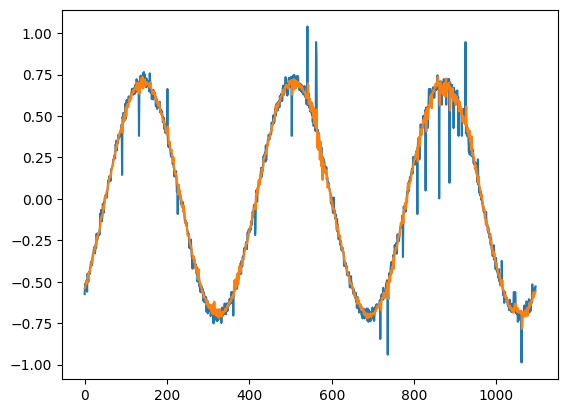

In [23]:
import matplotlib.pyplot as plt
plt.plot(y_test_temp)
plt.plot(prediction)

### Humidity prediction from VAR Model

In [24]:
"""humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)
            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)"""

'humid_pred= 0.20*humid(t-1)+0.03*pressure(t-3)+0.04*pressure(t-10)+0.03*humid(t-11)+0.05*temp(t-28)+0.04*humid(t-28)\n            -0.04*temp(t-32)+0.04*temp(t-37)+0.03*pressure(t-37)-0.04*pressure(t-38)-0.04*humid(t-47)-0.04*pressure(t-48)'

In [25]:
df_laggedhumid=pd.DataFrame()
df_laggedhumid['humid_L1']=df_combined['ScaledHumid'].shift(1)
df_laggedhumid['pressure_L3']=df_combined['ScaledPressure'].shift(3)
df_laggedhumid['pressure_L10']=df_combined['ScaledPressure'].shift(10)
df_laggedhumid['humid_L11']=df_combined['ScaledHumid'].shift(11)
df_laggedhumid['temp_L28']=df_combined['ScaledTemp'].shift(28)
df_laggedhumid['humid_L28']=df_combined['ScaledHumid'].shift(28)
df_laggedhumid['temp_L32']=df_combined['ScaledTemp'].shift(32)
df_laggedhumid['temp_L37_dVarHumid']=df_combined['ScaledTemp'].shift(37)
df_laggedhumid['pressure_L37']=df_combined['ScaledPressure'].shift(37)
df_laggedhumid['pressure_L38_dVarHumid']=df_combined['ScaledPressure'].shift(38)
df_laggedhumid['humid_L47']=df_combined['ScaledHumid'].shift(47)
df_laggedhumid['pressure_L48']=df_combined['ScaledPressure'].shift(48)

In [26]:
df_varhumid=[df_laggedhumid['humid_L1'],df_laggedhumid['pressure_L3'],df_laggedhumid['pressure_L10'],
             df_laggedhumid['humid_L11'],df_laggedhumid['temp_L28'],df_laggedhumid['humid_L28'],df_laggedhumid['temp_L32'],
             df_laggedhumid['temp_L37_dVarHumid'],df_laggedhumid['pressure_L37'],
             df_laggedhumid['pressure_L38_dVarHumid'],df_laggedhumid['humid_L47'],
             df_laggedhumid['pressure_L48'],df_combined['ScaledHumid']]
df_varhumid=pd.concat(df_varhumid,axis=1)

In [27]:
df_varhumid.dropna(inplace=True)

In [28]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_humid = df_varhumid.iloc[:-nest_samples].copy()
test_humid = df_varhumid.iloc[-nest_samples:].copy()

y_train_humid = train_humid.iloc[:, -1].values
y_test_humid = test_humid.iloc[:, -1].values

X_train_humid=train_humid.iloc[:,:-1].values
x_test_humid=test_humid.iloc[:,:-1].values

### Build Custom Layer

In [29]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, coeffs):
        super(CustomLayer, self).__init__()
        self.coeffs = coeffs

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[self.coeffs])

    def call(self, inputs):
        return inputs*self.kernel

In [30]:
input_tensor = Input(shape=(12,))
Mul_output = CustomLayer(12)(input_tensor)
humid = tf.reduce_sum(Mul_output, axis= -1, keepdims=True)
model_humid = Model(input_tensor, humid)

In [31]:
model_humid.compile(loss='mean_absolute_error', optimizer='adam')

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.0001, mode ="min", restore_best_weights=True)
history = model_humid.fit(X_train_humid, y_train_humid, epochs=100, batch_size=16, verbose=1, validation_split=0.1, callbacks=[callback])

Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 0.2048 - val_loss: 0.0708
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0579 - val_loss: 0.0482
Epoch 3/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0519 - val_loss: 0.0480
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0509 - val_loss: 0.0458
Epoch 5/100
244/244 [==============================] - 1s 5ms/step - loss: 0.0497 - val_loss: 0.0451
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0486 - val_loss: 0.0436
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0477 - val_loss: 0.0426
Epoch 8/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0468 - val_loss: 0.0416
Epoch 9/100
244/244 [==============================] - 1s 5ms/step - loss: 0.0457 - val_loss: 0.0406
Epoch 10/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0447 - val_lo

In [33]:
prediction_humid = model_humid.predict(x_test_humid)

35/35 [==============================] - 0s 4ms/step


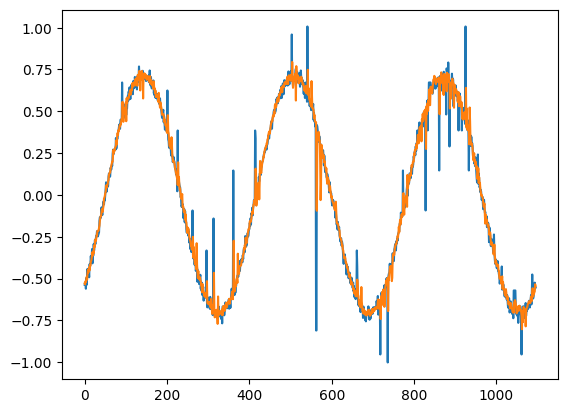

In [34]:
import matplotlib.pyplot as plt
plt.plot(y_test_humid)
plt.plot(prediction_humid)

### Pressure prediction from VAR Model

In [35]:
"""pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)
                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)
                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)"""

'pressure_pred= 0.03*humid(t-1)+0.09*pressure(t-1)+0.03*humid(t-2)+0.04*temp(t-6)+0.03*pressure(t-10)+0.05*temp(t-12)\n                 +0.04*pressure(t-12)+0.03*humid(t-15)+0.03*pressure(t-18)+0.03*temp(t-19)-0.07*temp(t-38)-0.03*humid(t-38)\n                  0.06*pressure(t-38)-0.04*temp(t-49)-0.03*humid(t-50)'

In [36]:
df_laggedpressure=pd.DataFrame()
df_laggedpressure['humid_L1_dVarPressure']=df_combined['ScaledHumid'].shift(1)
df_laggedpressure['pressure_L1']=df_combined['ScaledPressure'].shift(1)
df_laggedpressure['humid_L2_dVarPressure']=df_combined['ScaledHumid'].shift(2)
df_laggedpressure['temp_L6_dVarPressure']=df_combined['ScaledTemp'].shift(6)
df_laggedpressure['pressure_L10_dVarPressure']=df_combined['ScaledPressure'].shift(10)
df_laggedpressure['temp_L12']=df_combined['ScaledTemp'].shift(12)
df_laggedpressure['pressure_L12']=df_combined['ScaledPressure'].shift(12)
df_laggedpressure['humid_L15_dVarPressure']=df_combined['ScaledHumid'].shift(15)
df_laggedpressure['pressure_L18_dVarPressure']=df_combined['ScaledPressure'].shift(18)
df_laggedpressure['temp_L19']=df_combined['ScaledTemp'].shift(19)
df_laggedpressure['temp_L38']=df_combined['ScaledTemp'].shift(38)
df_laggedpressure['humid_L38']=df_combined['ScaledHumid'].shift(38)
df_laggedpressure['pressure_L38_dVarPressure']=df_combined['ScaledPressure'].shift(38)
df_laggedpressure['temp_49_dVarPressure']=df_combined['ScaledTemp'].shift(49)
df_laggedpressure['humid_L50']=df_combined['ScaledHumid'].shift(50)

In [37]:
df_varpressure=[df_laggedpressure['humid_L1_dVarPressure'],df_laggedpressure['pressure_L1'],
                        df_laggedpressure['humid_L2_dVarPressure'],
                        df_laggedpressure['temp_L6_dVarPressure'],df_laggedpressure['pressure_L10_dVarPressure'],
                        df_laggedpressure['temp_L12'],
                        df_laggedpressure['pressure_L12'],df_laggedpressure['humid_L15_dVarPressure'],
                        df_laggedpressure['pressure_L18_dVarPressure'],df_laggedpressure['temp_L19'],
                        df_laggedpressure['temp_L38'],df_laggedpressure['humid_L38'],
                        df_laggedpressure['pressure_L38_dVarPressure'],
                        df_laggedpressure['temp_49_dVarPressure'],df_laggedpressure['humid_L50'],df_combined['ScaledPressure']]
df_varpressure=pd.concat(df_varpressure,axis=1)

In [38]:
df_varpressure.dropna(inplace=True)

In [39]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_pressure = df_varpressure.iloc[:-nest_samples].copy()
test_pressure = df_varpressure.iloc[-nest_samples:].copy()

y_train_pressure = train_pressure.iloc[:, -1].values
y_test_pressure = test_pressure.iloc[:, -1].values

X_train_pressure=train_pressure.iloc[:,:-1].values
x_test_pressure=test_pressure.iloc[:,:-1].values

### Build Custom Layer

In [40]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, coeffs):
        super(CustomLayer, self).__init__()
        self.coeffs = coeffs

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[self.coeffs])

    def call(self, inputs):
        return inputs*self.kernel

In [41]:
input_tensor = Input(shape=(15,))
Mul_output = CustomLayer(15)(input_tensor)
pressure = tf.reduce_sum(Mul_output, axis= -1, keepdims=True)
model_pressure = Model(input_tensor, pressure)

In [42]:
model_pressure.compile(loss='mean_absolute_error', optimizer='adam')

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.0001, mode ="min", restore_best_weights=True)
history = model_pressure.fit(X_train_pressure, y_train_pressure, epochs=100, batch_size=16, verbose=1, validation_split=0.1, callbacks=[callback])

Epoch 1/100
244/244 [==============================] - 2s 5ms/step - loss: 0.0496 - val_loss: 0.0404
Epoch 2/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0422 - val_loss: 0.0380
Epoch 3/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0409 - val_loss: 0.0379
Epoch 4/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0399 - val_loss: 0.0361
Epoch 5/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0388 - val_loss: 0.0350
Epoch 6/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0380 - val_loss: 0.0341
Epoch 7/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0371 - val_loss: 0.0331
Epoch 8/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0364 - val_loss: 0.0324
Epoch 9/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0356 - val_loss: 0.0321
Epoch 10/100
244/244 [==============================] - 1s 4ms/step - loss: 0.0352 - val_lo

In [44]:
prediction_pressure = model_pressure.predict(x_test_pressure)

35/35 [==============================] - 0s 3ms/step


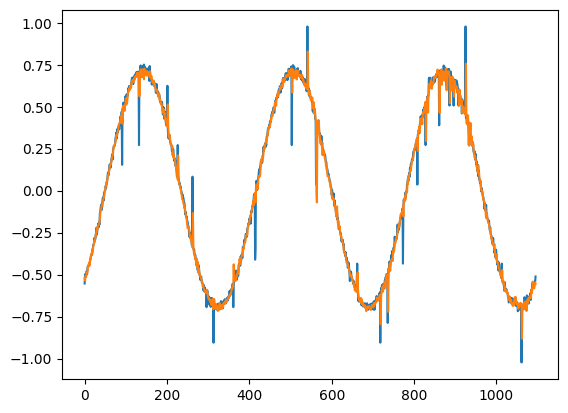

In [45]:
import matplotlib.pyplot as plt
plt.plot(y_test_pressure)
plt.plot(prediction_pressure)

In [46]:
#test_data
data_temp_test = pd.DataFrame({'predicted_temp': prediction.squeeze(), 'actual_temp': y_test_temp})
data_humidity_test = pd.DataFrame({'predicted_humid': prediction_humid.squeeze(), 'actual_humid': y_test_humid})
data_pressure_test = pd.DataFrame({'predicted_pressure': prediction_pressure.squeeze(), 'actual_pressure': y_test_pressure})
data_kNN_test=pd.concat([data_temp_test,data_humidity_test,data_pressure_test],axis=1)

In [47]:
Ntest=1096
le=LabelEncoder()

y = data_labeled.iloc[:, -1].values
ground_truth_train = y[:-Ntest].copy()
ground_truth_test = y[-Ntest:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

In [48]:
# Use PyOD's KNN model for anomaly detection
knn_model = KNN()
knn_model.fit(data_kNN_test)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [49]:
prediction_scores = knn_model.decision_function(data_kNN_test)
prediction_labels = knn_model.predict(data_kNN_test)  # raw outlier scores. The higher, the more abnormal.

In [50]:
unique, counts = np.unique(prediction_labels, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_test), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (prediction_labels != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, prediction_labels, squared=False)
mae = mean_absolute_error(ground_truth_test, prediction_labels)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)


Outlier prediction information on Test Data: 1096 {0: 991, 1: 105}
No of Errors in test set: 71

RMS on Test Set : 0.2545211619842449

MAE on Test Set : 0.06478102189781022


In [51]:
#Confusion Matrix.
from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, knn_model.predict(data_kNN_test))

array([[984,  64],
       [  7,  41]], dtype=int64)

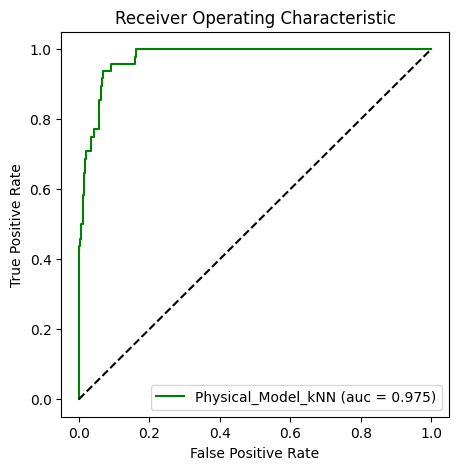

In [52]:
# Calculate AUC-ROC score
auc_roc_pm = roc_auc_score(ground_truth_test, prediction_scores)
fpr_pm, tpr_pm, thresholds_pm = roc_curve(ground_truth_test, prediction_scores)
auc_kNN_pm = auc(fpr_pm,tpr_pm)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr_pm, tpr_pm, linestyle='-', color='g', label='Physical_Model_kNN (auc = %0.3f)' % auc_kNN_pm)

plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()